In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [ ]:
class MLModelTrainer:
    def __init__(self, test_size=0.8, random_state=1):
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.metrics = {}
        self.models = {} 
        self.y_preds = {}

    def load_data(self, data_path):
        # Load data from a CSV file
        # Check the file extension to determine the appropriate reading method
        if data_path.endswith('.parquet'):
            self.data = pd.read_parquet(data_path)
        elif data_path.endswith('.csv'):
            self.data = pd.read_csv(data_path)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .parquet file.")

    def data_split(self, cols_drop, tgt_col=["price actual"]):
        # Split and scale the data
        len_data = math.floor(len(self.data) * self.test_size)
        self.df_train = self.data[:len_data]
        self.df_val = self.data[len_data:]

        cols_drop = cols_drop + tgt_col

        # Create the tranining and validation dataset
        self.X_train = self.df_train.drop(columns=cols_drop)
        self.X_val = self.df_val.drop(columns=cols_drop)
        self.y_train = self.df_train[tgt_col]
        self.y_val = self.df_val[tgt_col]

        # One-hot encode categorical variables
        self.X_train = pd.get_dummies(self.X_train,drop_first=True)
        self.X_val = pd.get_dummies(self.X_val,drop_first=True)
        self.X_val = self.X_val.reindex(columns=self.X_train.columns, fill_value=False)
        
        #print(self.X_train.info())
        # Separate numeric and boolean columns for training data
        numeric_cols_train = self.X_train.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_train = self.X_train.select_dtypes(include=['bool']).columns

        # Initialize the StandardScaler
        self.scaler = StandardScaler()

        # Fit and transform the numeric data
        scaled_numeric_train = self.scaler.fit_transform(self.X_train[numeric_cols_train])

        # Create a DataFrame with the scaled numeric data
        scaled_numeric_train_df = pd.DataFrame(scaled_numeric_train, columns=numeric_cols_train)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame
        self.X_train = pd.concat([scaled_numeric_train_df, self.X_train[boolean_cols_train].reset_index(drop=True)], axis=1)

        # For validation data, scale numeric columns
        numeric_cols_val = self.X_val.select_dtypes(include=['float64', 'int64']).columns
        scaled_numeric_val = self.scaler.transform(self.X_val[numeric_cols_val])

        # Create a DataFrame with the scaled numeric data for validation
        scaled_numeric_val_df = pd.DataFrame(scaled_numeric_val, columns=numeric_cols_val)

        # Combine the scaled numeric DataFrame with the original boolean DataFrame for validation
        self.X_val = pd.concat([scaled_numeric_val_df, self.X_val[boolean_cols_train].reset_index(drop=True)], axis=1)

        # Prepare the full dataset for return
        X = pd.get_dummies(self.data.drop(columns=cols_drop),drop_first=True)
        numeric_cols_full = X.select_dtypes(include=['float64', 'int64']).columns
        boolean_cols_full = X.select_dtypes(include=['bool']).columns

        # Scale the numeric columns of the full dataset
        X_scaled = self.scaler.transform(X[numeric_cols_full])
        X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols_full)

        # Combine with the original boolean columns
        self.X = pd.concat([X_scaled_df, X[boolean_cols_full].reset_index(drop=True)], axis=1)

 
        self.y = self.data[tgt_col]

   
    def train(self, models):
        # Fit multiple models based on dictionary input
        # Models is a dictionary made up model names as keys and values as model initializer
        for model_name, model in models.items():
            model.fit(self.X_train, self.y_train)
            self.models[model_name] = model 
            print(f"{model_name} finished training")

    def evaluate(self):
        # Based of fitted models, evaluate and store metrics as a dictionary based on model name
        metrics_results = {}
        for model_name, model in self.models.items():
            # Make predictions
            y_pred = model.predict(self.X_val)
            
            if self.X_val is None or self.y_val is None:
                raise ValueError("Validation data is not available")
            # Calculate metrics
            mae = mean_absolute_error(self.y_val, y_pred)
            mse = mean_squared_error(self.y_val, y_pred)
            rmse = root_mean_squared_error(self.y_val, y_pred)
            r2 = r2_score(self.y_val, y_pred)
            # Store y_pred
            self.y_preds[model_name] = y_pred
            # Store metrics
            metrics_results[model_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                "r2": r2
            }
        self.metrics = metrics_results
        return metrics_results

    def print_metrics(self):
        # Print the metrics
        
        #Checks if self.models exist
        if not self.models:
            raise ValueError("Train the models")
        #Evalutaes if no metrics exist
        if not self.metrics or (len(self.metrics) != len(self.models)):
            self.evaluate()
            
        #Print the metrics
        for model_name, metrics in self.metrics.items():
            print(f"Metrics for {model_name} model:")
            for metric_name, value in metrics.items():
                print(f"  {metric_name}: {value:.2f}")
            print() 

    def grid_search_train(self, model_and_params, n_splits=5):
        # Performs a grid search with time series cross-validation based on input models
        # model_and_params: dict, where keys are model names and values are tuples of (model, param_grid).
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for model_name, (model, param_grid) in model_and_params.items():
            print(f"\nRunning grid search for {model_name} using TimeSeriesSplit...")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            grid_search.fit(self.X_train, self.y_train.values.ravel())
            self.models[model_name] = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")

In [3]:
#import datasets
energy = MLModelTrainer()
energy.load_data(r"data\energy_dataset.csv")

In [4]:
#import datasets
weather = MLModelTrainer()
weather.load_data(r"data\weather_features.csv")

In [5]:
energy.data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [6]:
weather.data.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:
energy.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [8]:
weather.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [9]:
#convert specific time column to dt format and rename for weather
energy.data["time"] = pd.to_datetime(energy.data["time"], utc = True)
weather.data["dt_iso"] = pd.to_datetime(weather.data["dt_iso"], utc = True)
weather.data = weather.data.rename(columns={'dt_iso': 'time'})

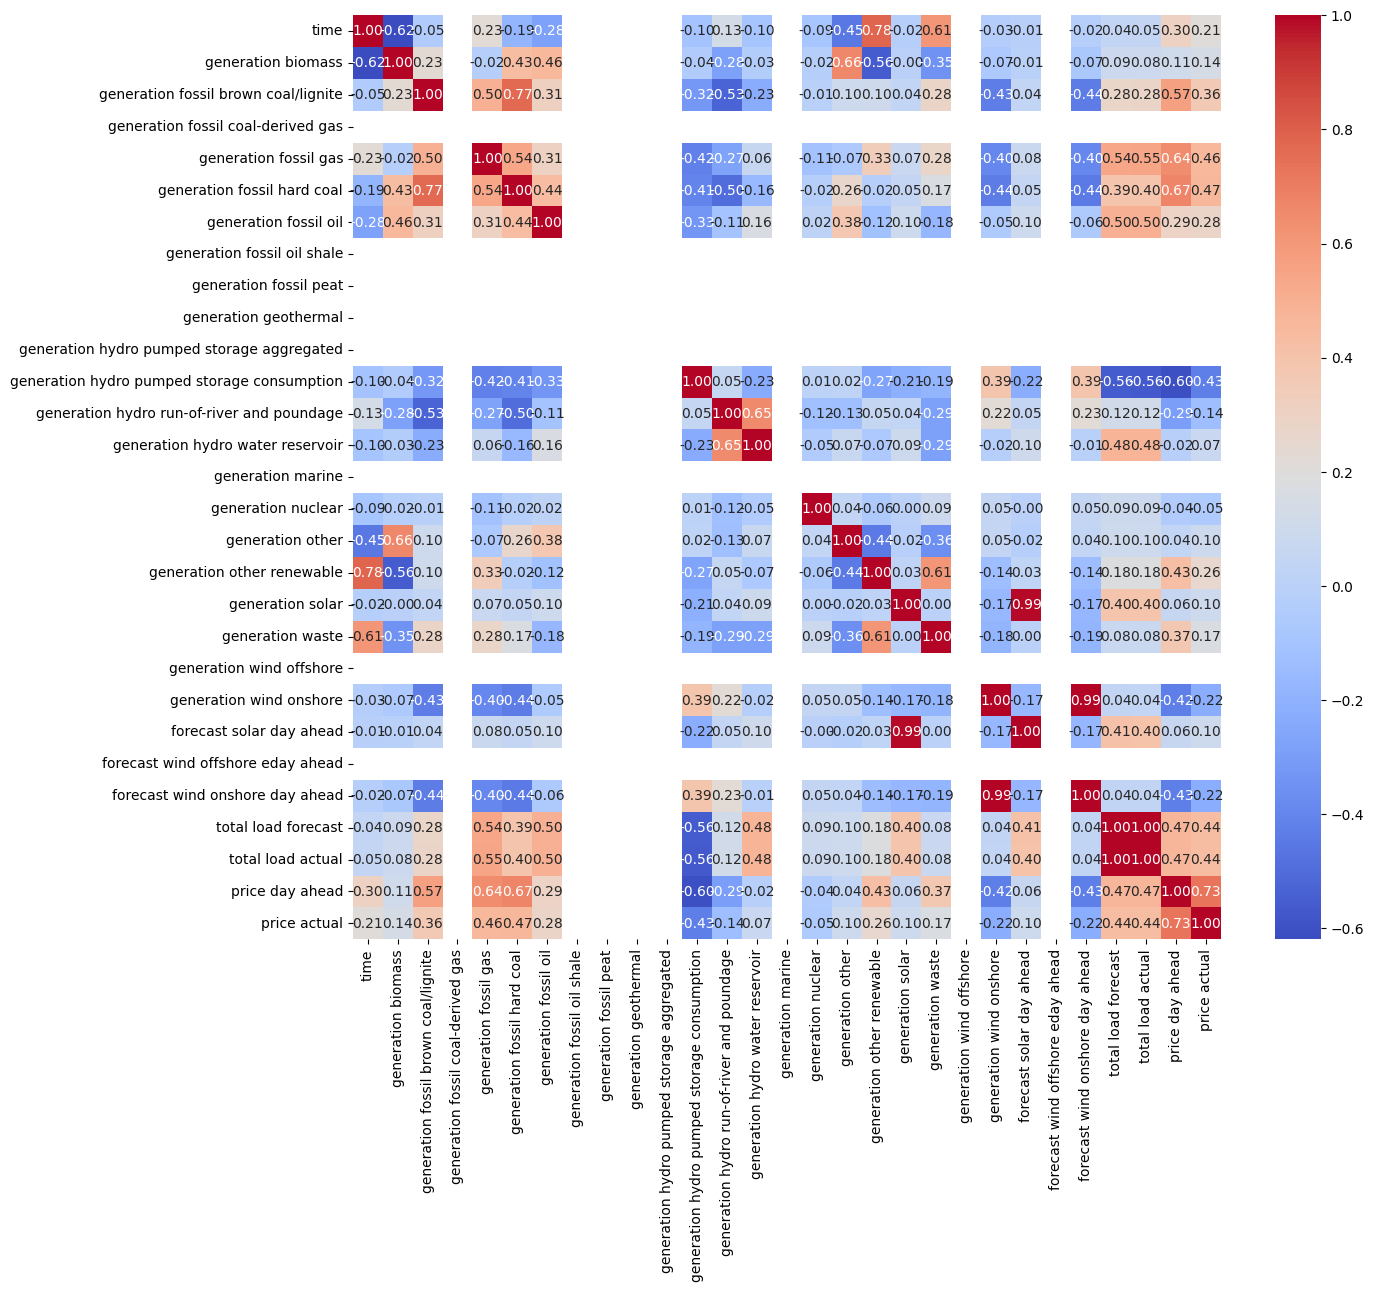

In [10]:
plt.figure(figsize=(14,12))
sns.heatmap(energy.data.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

Exploration of the energy dataset

In [11]:
len(energy.data["time"].unique()) == len(energy.data)

True

In [12]:
energy.data.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


Some features have outlandish outliers. But considering, a technology will start generating when its generation revenue will exceed operating costs. For example, solar panel power is far cheaper than burning fuel with a coal burning plant in terms of power production.

There are several features that contain one unique value. In this case, those forms of generation do not come on at any point within the dataset. The features are generation fossil oil shale, generation fossil peat, generation geothermal, generation marine, generation wind offshore, generation fossil coal-derived gas. Additionally, per the correlation heatmap, there is no correlation to other features.

In [13]:
#No correlation with other columns and are have a min and max of 0
energy_cols_to_drop = ['forecast wind offshore eday ahead',  "generation fossil oil shale", "generation fossil peat", "generation geothermal", 
                "generation marine", "generation wind offshore",  "generation fossil coal-derived gas", "generation hydro pumped storage aggregated"]

energy.data.drop(columns=energy_cols_to_drop,inplace=True)

In [14]:
# Export a portion of the dataset
to_save_energy_df = energy.data[math.floor(len(energy.data)*0.8):]
to_save_energy_df.to_csv("engineered_data\energy_data_val_manipulated.csv",index=False)

In [15]:
energy.data.select_dtypes(include=[np.number]).skew()


generation biomass                             0.421013
generation fossil brown coal/lignite          -0.046831
generation fossil gas                          1.615447
generation fossil hard coal                   -0.073691
generation fossil oil                          0.064469
generation hydro pumped storage consumption    2.130588
generation hydro run-of-river and poundage     0.500928
generation hydro water reservoir               0.897036
generation nuclear                            -0.691683
generation other                              -0.506196
generation other renewable                    -0.216073
generation solar                               1.020388
generation waste                              -0.849129
generation wind onshore                        0.785008
forecast solar day ahead                       0.990018
forecast wind onshore day ahead                0.800419
total load forecast                            0.059873
total load actual                              0

In [16]:
energy.data.select_dtypes(include=[np.number]).kurt()


generation biomass                            -0.283427
generation fossil brown coal/lignite          -1.456085
generation fossil gas                          3.185433
generation fossil hard coal                   -1.123963
generation fossil oil                          0.066915
generation hydro pumped storage consumption    4.197127
generation hydro run-of-river and poundage    -0.720289
generation hydro water reservoir               0.174425
generation nuclear                            -0.501065
generation other                               0.443097
generation other renewable                    -0.826647
generation solar                              -0.387780
generation waste                               0.141367
generation wind onshore                        0.057888
forecast solar day ahead                      -0.440854
forecast wind onshore day ahead                0.101958
total load forecast                           -0.930861
total load actual                             -0

Disregarding outliers, most features tend to follow a normal distribution. I would like the model capture the outliers as typically, prices are the highest in extreme/outlier events.

In [17]:
energy.data.isnull().sum()


time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0


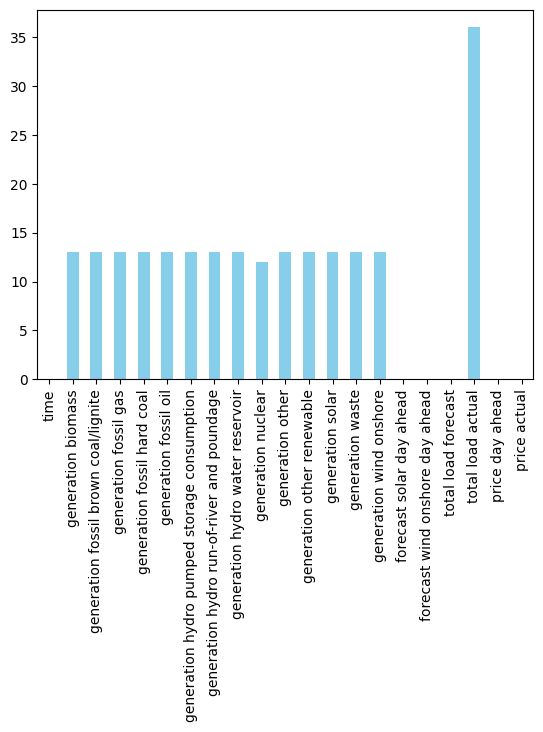

In [18]:
#Plots histogram of null values for all features in energy when total load actual is null
energy.data[energy.data["total load actual"].isna()] .isna().sum().plot(kind='bar', color='skyblue')
plt.show()

Values are likely null when there is trouble with the grid, such as outages affecting most generation related features at once. Compared to the dataset size, the count of the NaN values are very low. Hence, fill by interpolation is best due to low amount of nans and correlation between the features

In [19]:
energy.data = energy.data.interpolate()

In [20]:
energy_generation_columns = ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore'
]
energy.data["total_gen"] = energy.data[energy_generation_columns].sum(axis=1)

Creating a new feature named total generation to enable the model to extrapolate better based on generation vs load

Weather Data exploration

In [21]:
# Check dtypes of columns
weather.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   time                 178396 non-null  datetime64[ns, UTC]
 1   city_name            178396 non-null  object             
 2   temp                 178396 non-null  float64            
 3   temp_min             178396 non-null  float64            
 4   temp_max             178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

In [22]:
print("Number of unique values in city_name: ", weather.data['city_name'].nunique())
print("Is the number of unique values in time equal to lenght of the weather dataset: ",len(weather.data["time"].unique()) == len(weather.data))
weather.data[weather.data["time"] == weather.data.loc[0, "time"] ]

Number of unique values in city_name:  5
Is the number of unique values in time equal to lenght of the weather dataset:  False


,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35145,2014-12-31 23:00:00+00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
71412,2014-12-31 23:00:00+00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,clear,sky is clear,01
107363,2014-12-31 23:00:00+00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800,clear,sky is clear,01n
142839,2014-12-31 23:00:00+00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Time is not a unique value as is in the energy dataset. To make time unique, city_name will be dropped and an unique column based on name of the city will be created. This is to ensure, an inner merging with the energy dataset will not result in a loss of values.

<Axes: >

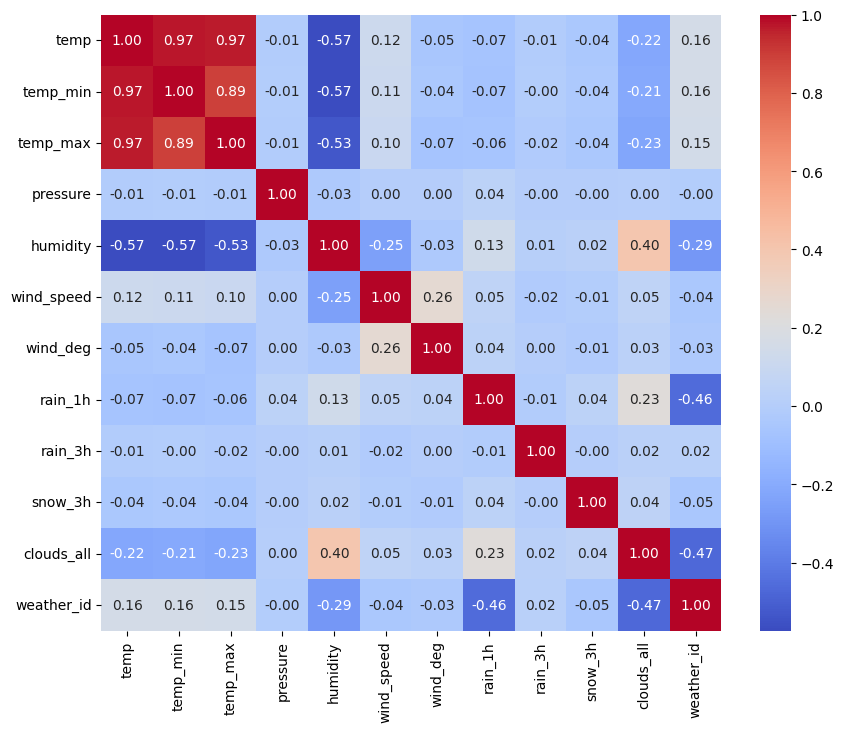

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(weather.data[weather.data.select_dtypes(include=['number']).columns].corr(),cmap ="coolwarm",annot=True,fmt=".2f")

As expected, temp, temp_min, and temp_max are highly correlated. There is little correlation of pressure, rain_1h, rain_3h, and snow_3h with other features. Additional correlation may exist with the energy predictors.

In [24]:
weather.data.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [25]:
weather.data.select_dtypes(include=[np.number]).skew()

temp            0.225004
temp_min        0.210634
temp_max        0.301690
pressure      159.865918
humidity       -0.525438
wind_speed      3.170403
wind_deg       -0.031376
rain_1h        15.893249
rain_3h       184.112534
snow_3h        68.835036
clouds_all      0.946844
weather_id     -2.747868
dtype: float64

In [26]:
weather.data.select_dtypes(include=[np.number]).kurt()

temp             -0.376944
temp_min         -0.328575
temp_max         -0.325644
pressure      26697.242300
humidity         -0.617298
wind_speed       97.124156
wind_deg         -1.366084
rain_1h         399.475183
rain_3h       57067.405699
snow_3h        5470.888864
clouds_all       -0.579049
weather_id        7.030404
dtype: float64

About half of the features follow a normal distribution

#pressure (hpa- 100pa), wind speed (m/s), rain (mm), and snow (mm) are abnormal https://openweathermap.org/weather-data for units

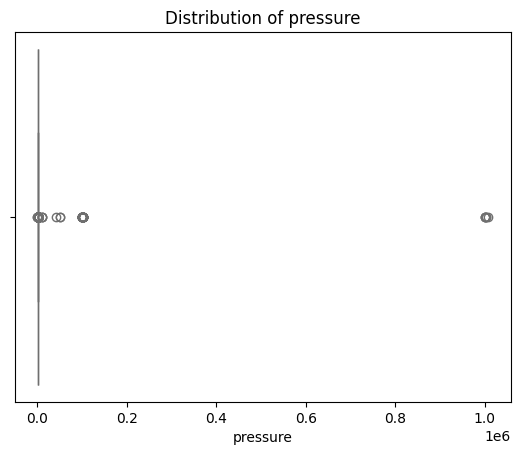

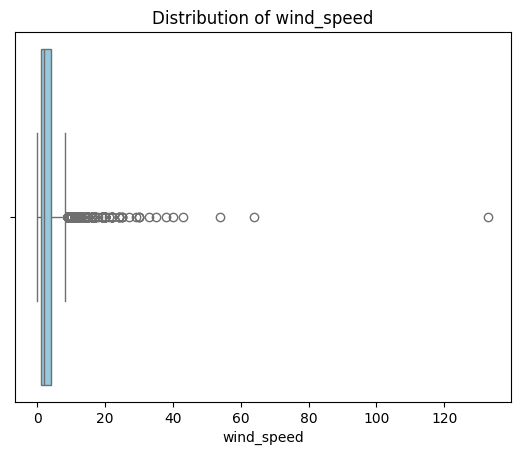

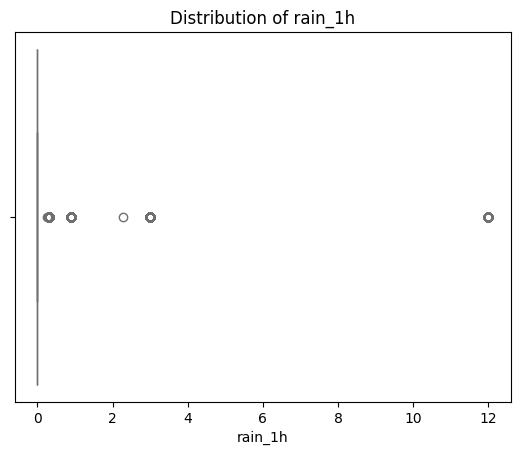

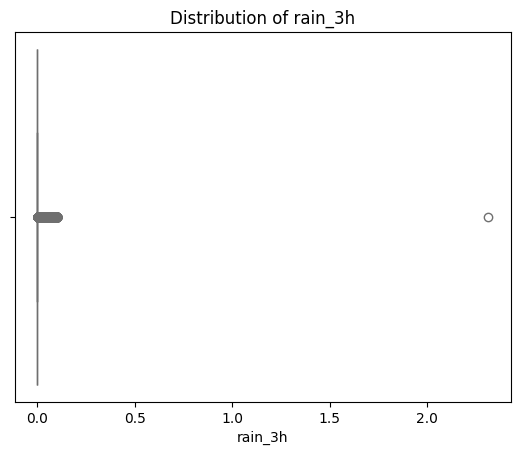

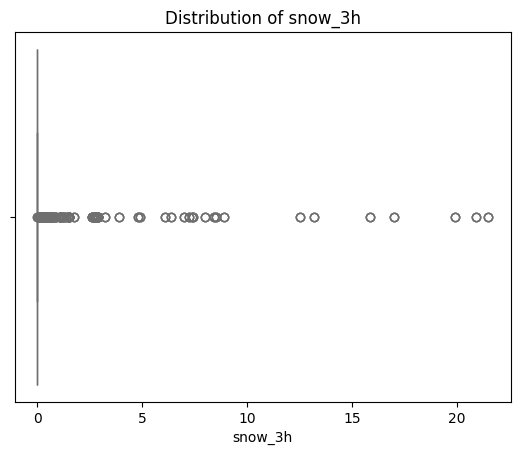

In [27]:
abnormal_weather_features = ["pressure","wind_speed","rain_1h","rain_3h","snow_3h"]
#plot the histogram for the values in abnormal_weather_features
for col in abnormal_weather_features:
    sns.boxplot(x=weather.data[col], color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.axis('auto')
    plt.show()



Snow is rare for the cities. The highest snowfall recorded for the five cities is for Madrid for 50 cm. No outliers will be removed for snow to catch extreme events and price increases. Rain_3h contains only 1 outlier and rain_1h has many. But outliers for both features are well below records. The outliers for rain will not be removed to capture extreme events. The highest recorded gust in Madrid is 33 m/s. Additionally, the highest value has higher speeds than a category five hurricane. The measurements are likely one-off measurements. Any value above 33 m/s will be removed. The highest and lowest pressure recorded was at Bilbao at a value of 1,048 hpa and 978 hpa respectively. Any values outside that range will be set to NaN.

In [28]:
# Filter based on the conditions
filtered_pressure = weather.data[(weather.data["pressure"] < 1048) & (weather.data["pressure"] > 978)]
filtered_wind_speed = weather.data[weather.data["wind_speed"] < 33]


# Calculate the lengths of the filtered DataFrames
len_weather_data = len(weather.data)

# Print the number of data points that are not valid for each condition
print(f"Number of invalid data points for pressure (not between 978 and 1048 hPa): {len_weather_data - len(filtered_pressure)}")
print(f"Number of invalid data points for wind speed (not less than 33 m/s): {len_weather_data - len(filtered_wind_speed)}")


Number of invalid data points for pressure (not between 978 and 1048 hPa): 4347
Number of invalid data points for wind speed (not less than 33 m/s): 8


In [29]:
# Make values outside of range null
weather.data.loc[(weather.data["pressure"] > 1048) | (weather.data["pressure"] < 978), "pressure"] = np.nan
weather.data.loc[weather.data["wind_speed"] >= 33, "wind_speed"] = np.nan


In [30]:
weather.data.loc[(weather.data["pressure"] > 1048) & (weather.data["pressure"] < 978), "pressure"]

Series([], Name: pressure, dtype: float64)

In [31]:
weather.data.isnull().sum()

time                      0
city_name                 0
temp                      0
temp_min                  0
temp_max                  0
pressure               4289
humidity                  0
wind_speed                8
wind_deg                  0
rain_1h                   0
rain_3h                   0
snow_3h                   0
clouds_all                0
weather_id                0
weather_main              0
weather_description       0
weather_icon              0
dtype: int64

In [32]:
#Null values for wind speed will be interpolated due to its small number of nans
weather.data['wind_speed'] = weather.data['wind_speed'].interpolate(method='linear')


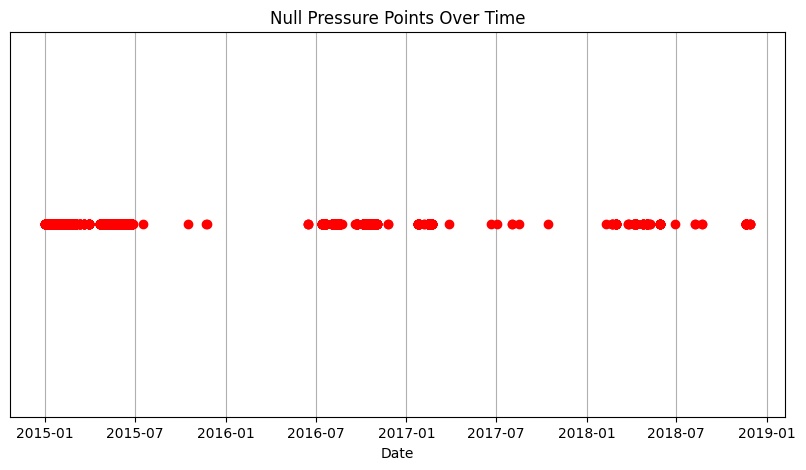

In [33]:
#plot pressure values over the years
pressure_null_pnts = weather.data[weather.data["pressure"].isnull()].fillna(0).reset_index()

plt.figure(figsize=(10, 5))
plt.plot(pressure_null_pnts['time'], [1]*len(pressure_null_pnts), 'ro') 
plt.title('Null Pressure Points Over Time')
plt.xlabel('Date')
plt.yticks([]) 
plt.grid()
plt.show()


Data is missing in large batches through the years. Bfill or ffill is not possible. For simplicity, the mean will be used.

In [34]:
weather.data['pressure'] = weather.data['pressure'].fillna(value=weather.data['pressure'].mean())

In [35]:
#Unique values of weather_id in the dataframe corresponding to other weather features
weather_id_comp = weather.data.drop_duplicates(subset=["weather_id"])[['weather_id', 'weather_main', 'weather_description', 'weather_icon']]
weather_id_comp

,weather_id,weather_main,weather_description,weather_icon
0,800,clear,sky is clear,01n
53,801,clouds,few clouds,02n
140,802,clouds,scattered clouds,03
141,803,clouds,broken clouds,04n
144,804,clouds,overcast clouds,04n
147,500,rain,light rain,10n
1026,501,rain,moderate rain,10d
1033,502,rain,heavy intensity rain,10
1497,701,mist,mist,50d
3843,522,rain,heavy intensity shower rain,09n


In [36]:
#export weather_id and related features
weather_id_comp.drop(columns=["weather_icon"]).to_csv("engineered_data\weather_id_descriptors.csv", index=False)

In [37]:
print("Number of unique values for weather_id: ", weather.data['weather_id'].nunique())
print("Number of unique values for weather_description: ", weather.data['weather_description'].nunique())
print("Number of unique values for weather_main: ", weather.data['weather_main'].nunique())
print("Number of unique values for weather_icon: ", weather.data['weather_icon'].nunique())


Number of unique values for weather_id:  38
Number of unique values for weather_description:  43
Number of unique values for weather_main:  12
Number of unique values for weather_icon:  24


Weather ID is a unique numeric identifier of the current weather. The columns,  "weather_main","weather_description", and "weather_icon" will be dropped.
 

In [38]:
weather.data = weather.data.drop(columns=["weather_main","weather_description","weather_icon"])

In [39]:
#export data
weather.data.to_csv("engineered_data\weather_data_val_manipulated.csv",index=False)

In [40]:
weather.data["temp_diff"] = weather.data["temp_max"] - weather.data["temp_min"]
weather.data.drop(columns=["temp_max","temp_min"],inplace=True)

In [41]:
df_weather = weather.data.copy()

In [42]:
#df_weather["weather_id"] = df_weather["weather_id"].astype(str)
#df_weather = pd.get_dummies(df_weather, columns=["weather_id"], prefix="weather_id")


In [43]:
#Creates new features based on city_name to make the time value unique for merging
cities = df_weather["city_name"].unique()
combined_data = MLModelTrainer()
combined_data.data = energy.data.copy()

for city in cities:
    #indexes values for a certain city name and drops the column
    df_city = df_weather[df_weather["city_name"] == city]
    df_city = df_city.drop(columns="city_name")
    
    #Duplicate times still exist within the weather dataset with a unique city. To gain a unique time, a 
    numeric_cols = df_city.select_dtypes(include=['number']).columns
    
    #Assigns the mean of duplicate time value entries to a unique time value
    df_city = df_city.groupby('time')[numeric_cols].agg('mean').reset_index()
    
    #Rename columns to include the city name
    for col in numeric_cols:
        df_city = df_city.rename(columns={col: col + "_" + city})
    
    #Merge the dfs
    combined_data.data = combined_data.data.merge(df_city, on="time", how="inner")

#Determines if duplicates exist in time
print(len(combined_data.data))
print(len(combined_data.data[energy.data.duplicated('time', keep=False)]))
print(len(combined_data.data[combined_data.data.duplicated('time', keep=False)]))

35064
0
0


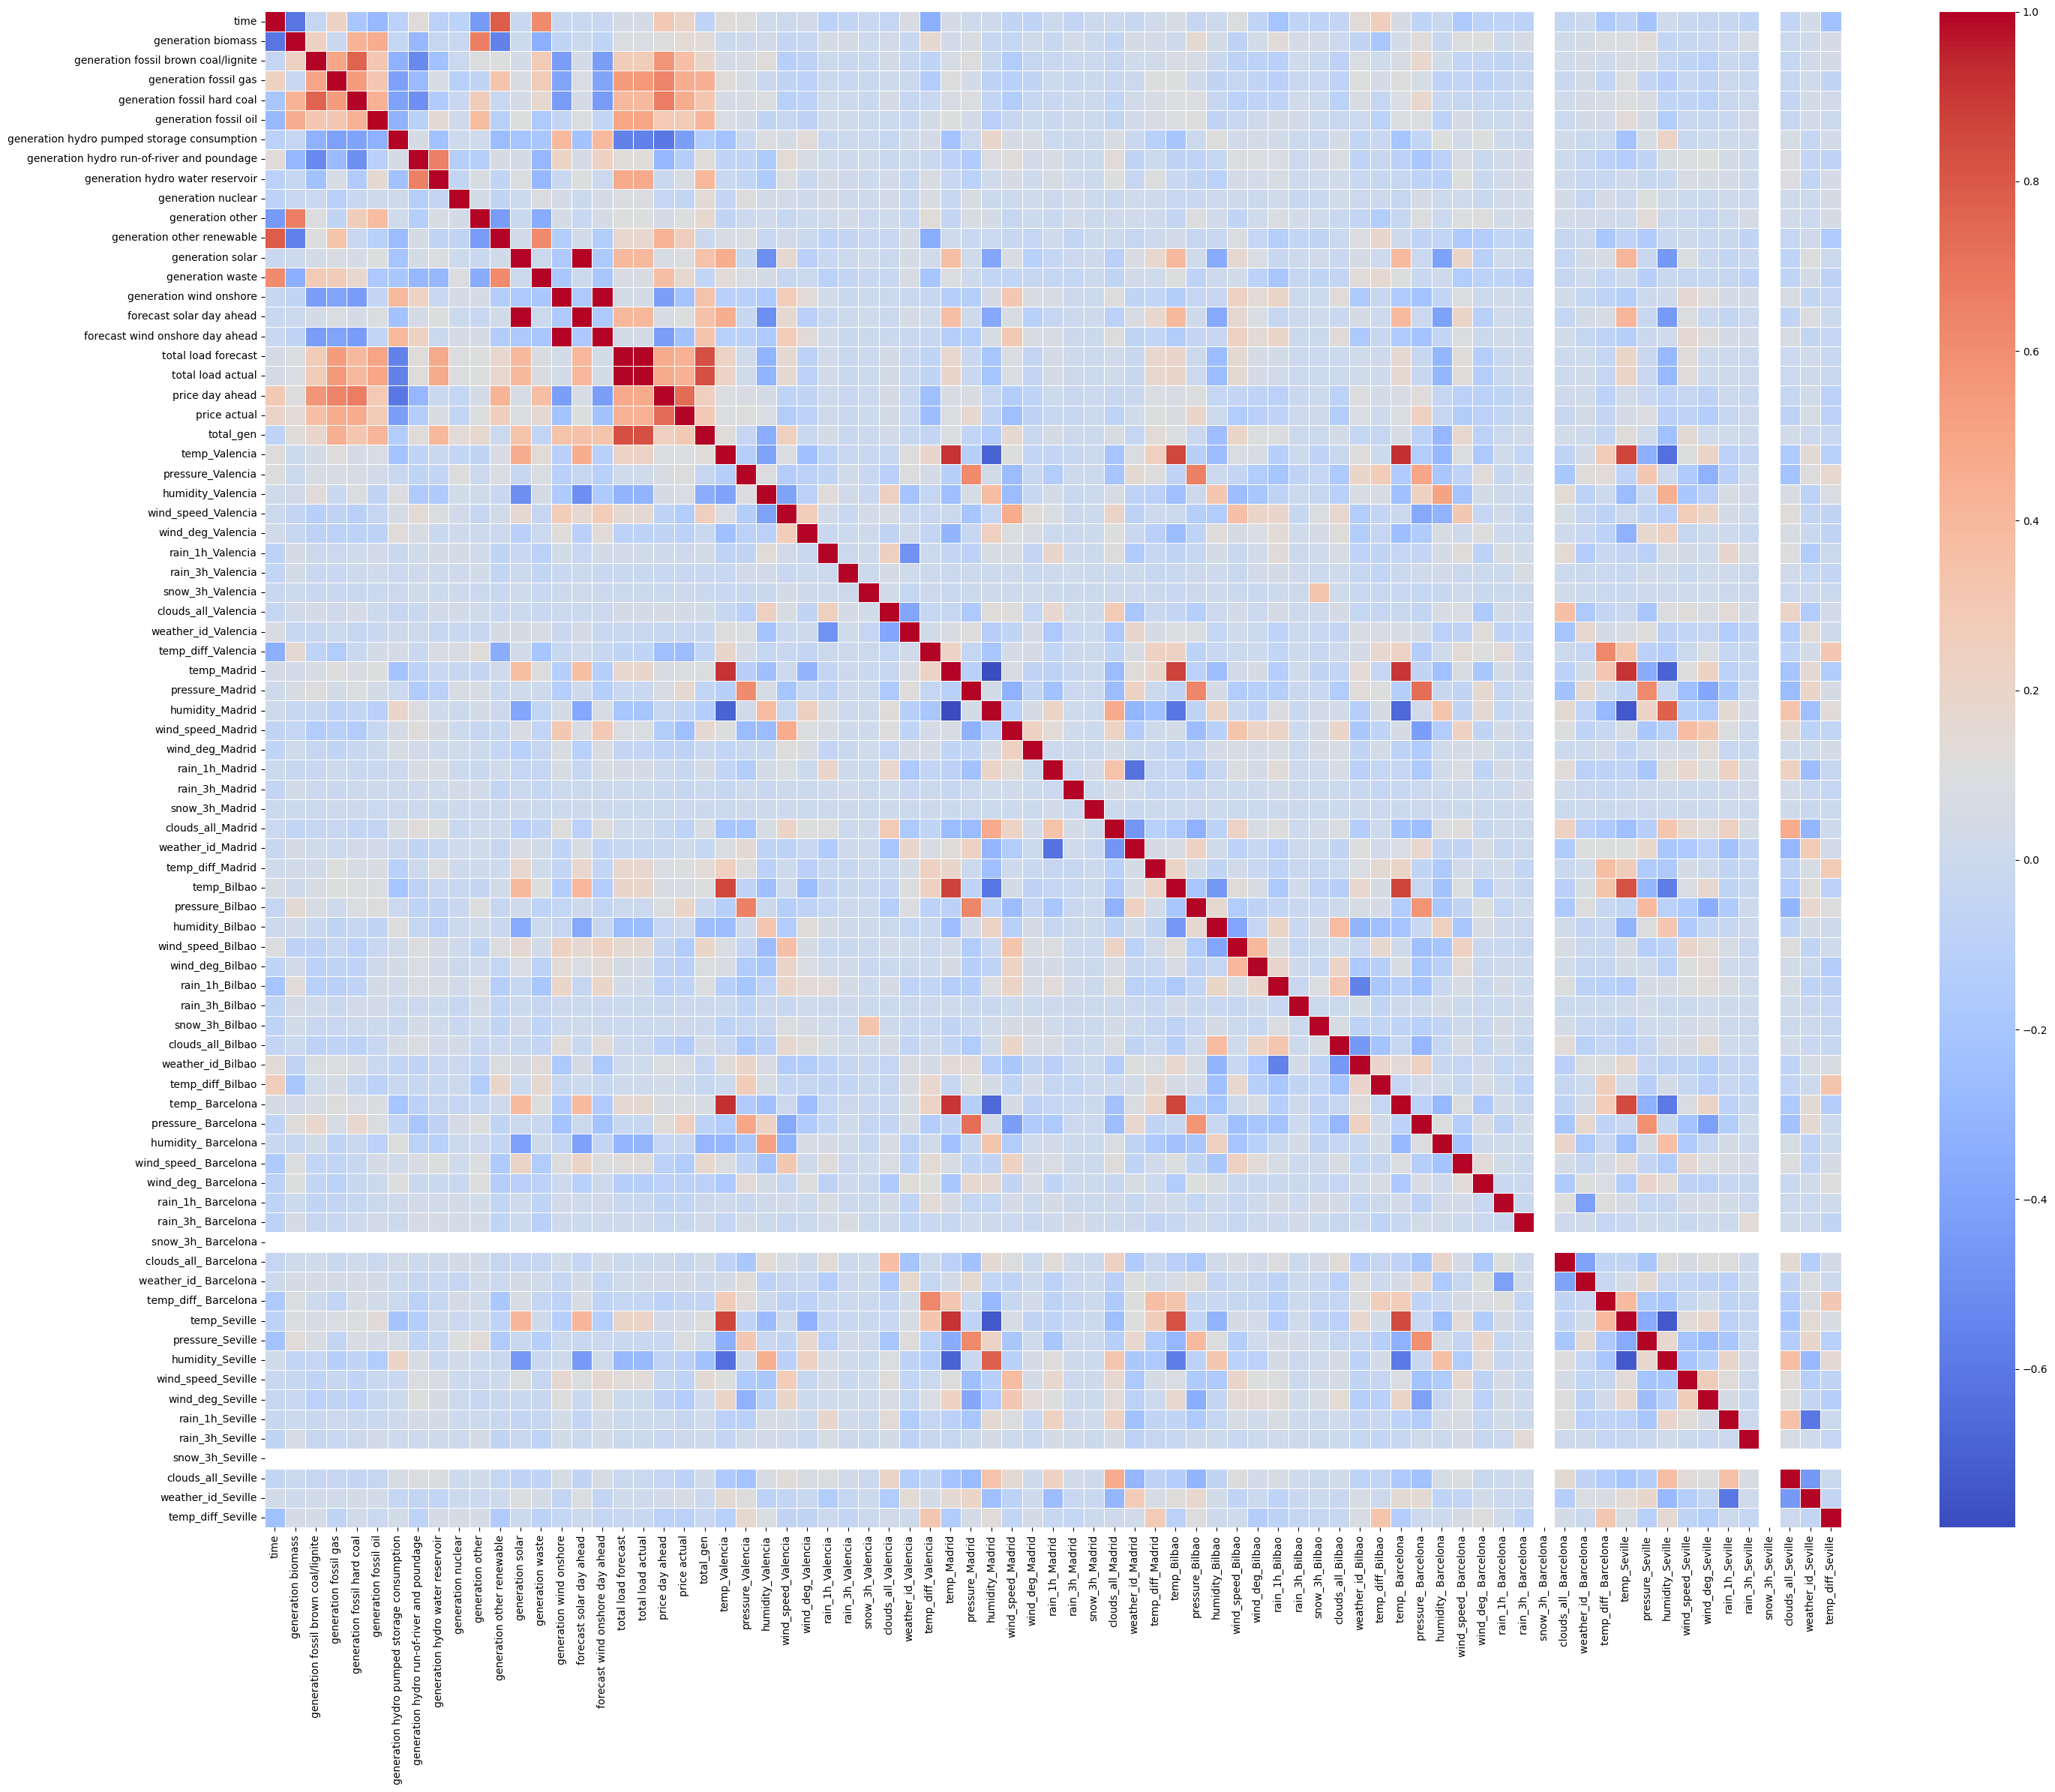

In [44]:
# Create the heatmap
plt.figure(figsize=(30, 24))
sns.heatmap(combined_data.data.corr(), cmap='coolwarm',fmt=".2f", linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

No correlation between 'snow_3h_ Barcelona' and 'snow_3h_Seville' and other features

In [45]:
#dropping snow_3h_ Barcelona and snow_3h_Seville
combined_data.data = combined_data.data.drop(['snow_3h_ Barcelona', 'snow_3h_Seville'], axis=1)

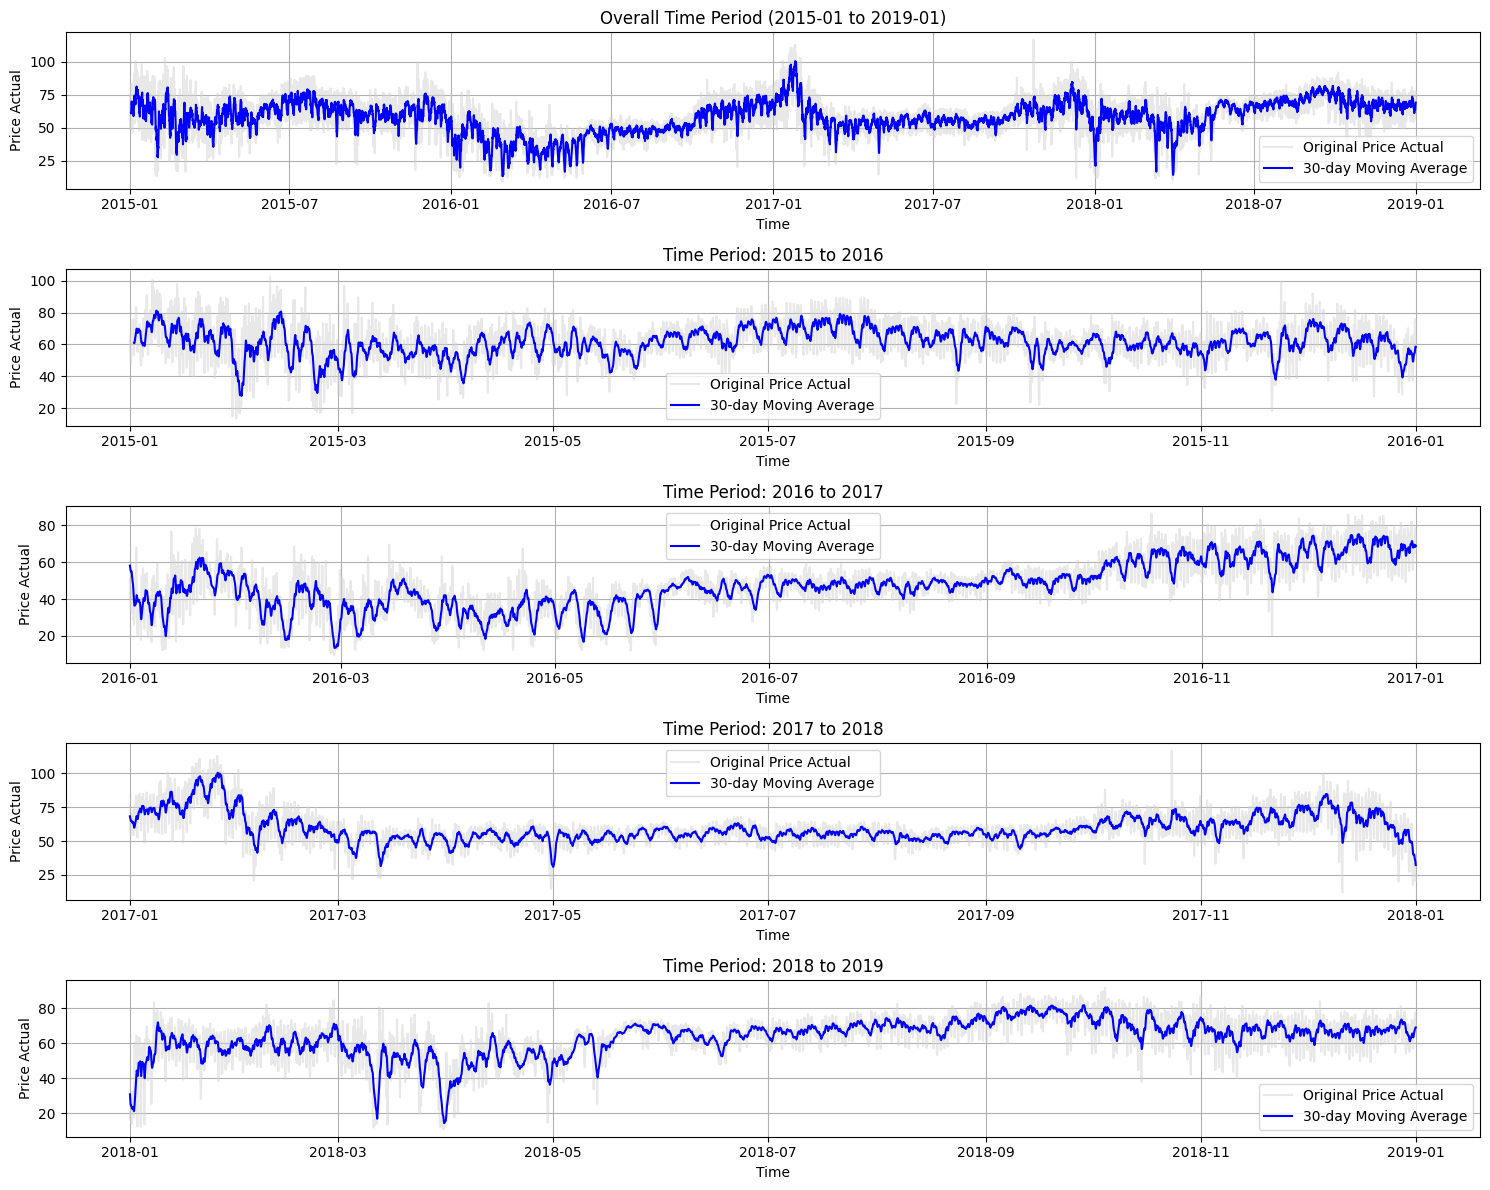

In [46]:
#Plot the moving averages for the entire time frame then years to determine if trends exists
df_30_day_ma = combined_data.data[['time', 'price actual']].copy()
df_30_day_ma['30_day_moving_average'] = df_30_day_ma['price actual'].rolling(window=30).mean() #Calculate the moving average

fig, axes = plt.subplots(5, 1, figsize=(15,12))
# Entire time period
axes[0].plot(df_30_day_ma["time"], df_30_day_ma["price actual"], label='Original Price Actual', color='lightgray', alpha=0.5) #Plots the time to price
axes[0].plot(df_30_day_ma["time"], df_30_day_ma["30_day_moving_average"], label='30-day Moving Average', color='blue') #plots time to 30 day moving average
axes[0].set_title('Overall Time Period (2015-01 to 2019-01)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price Actual')
axes[0].legend()
axes[0].grid()

# Separated years
for i in range(1, 5):
    start_year = 2015 + (i - 1)
    end_year = start_year + 1
    yearly_data = df_30_day_ma[(df_30_day_ma['time'] >= f'{start_year}-01-01') & (df_30_day_ma['time'] < f'{end_year}-01-01')]
    
    axes[i].plot(yearly_data["time"], yearly_data["price actual"], label='Original Price Actual', color='lightgray', alpha=0.5) #Plots the time to price
    axes[i].plot(yearly_data["time"], yearly_data["30_day_moving_average"], label='30-day Moving Average', color='blue') #plots time to 30 day moving average
    axes[i].set_title(f'Time Period: {start_year} to {end_year}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Price Actual')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


In [47]:
def plot_timeframe_data(data, y):
    #The function takes in a dataframe and a string present in data.columns
    #Plots a break down of the mean and standard deviations based on year, month, day, and hour to determine trends
    y_capitalized = y.title()
    if y not in data.columns:
        raise ValueError("Passed feature name not in dataframe")
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))

    # Yearly graph
    #Filter data to include only entries from January 1, 2015 as 1 data point exists in 2014. This to make the graph connected.
    filtered_data_year = data[data["time"] >= "2015-01-01"]

    mean_yearly = filtered_data_year.groupby(filtered_data_year["time"].dt.year)[y].mean()
    std_yearly = filtered_data_year.groupby(filtered_data_year["time"].dt.year)[y].std()

    sns.lineplot(x=mean_yearly.index, y=mean_yearly.values, ax=axes[0], label='Mean Price')
    axes[0].fill_between(mean_yearly.index, mean_yearly - std_yearly, mean_yearly + std_yearly, alpha=0.2, label='±1 Std Dev')
    axes[0].set_title(f'{y_capitalized} Per Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel(y_capitalized)
    axes[0].legend()


    # Monthly graph
    mean_monthly = data.groupby(data["time"].dt.month)[y].mean()
    std_monthly = data.groupby(data["time"].dt.month)[y].std()
    sns.lineplot(x=mean_monthly.index, y=mean_monthly.values, ax=axes[1], label='Mean Price', color="green")
    axes[1].fill_between(mean_monthly.index, mean_monthly - std_monthly, mean_monthly + std_monthly, alpha=0.2, color="green",label='±1 Std Dev')
    axes[1].set_title(f'{y_capitalized} Per Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel(y_capitalized)
    axes[1].legend()

    # Daily graph
    mean_daily = data.groupby(data['time'].dt.day_of_week)[y].mean()
    std_daily = data.groupby(data['time'].dt.day_of_week)[y].std()
    sns.lineplot(x=mean_daily.index, y=mean_daily.values, ax=axes[2], label='Mean Price', color="purple")
    axes[2].fill_between(mean_daily.index, mean_daily - std_daily, mean_daily + std_daily, alpha=0.2, color="purple", label='±1 Std Dev')
    axes[2].set_title(f'{y_capitalized} Per Day')
    axes[2].set_xlabel('Day')
    axes[2].set_ylabel(y_capitalized)
    axes[2].legend()

    # Hourly graph
    mean_hourly = data.groupby(data['time'].dt.hour)[y].mean()
    std_hourly = data.groupby(data['time'].dt.hour)[y].std()
    sns.lineplot(x=mean_hourly.index, y=mean_hourly.values, ax=axes[3], label='Mean Price', color="orange")
    axes[3].fill_between(mean_hourly.index, mean_hourly - std_hourly, mean_hourly + std_hourly, alpha=0.2, color="orange",label='±1 Std Dev')
    axes[3].set_title(f'{y_capitalized} Per Hour')
    axes[3].set_xlabel('Hour')
    axes[3].set_ylabel(y_capitalized)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

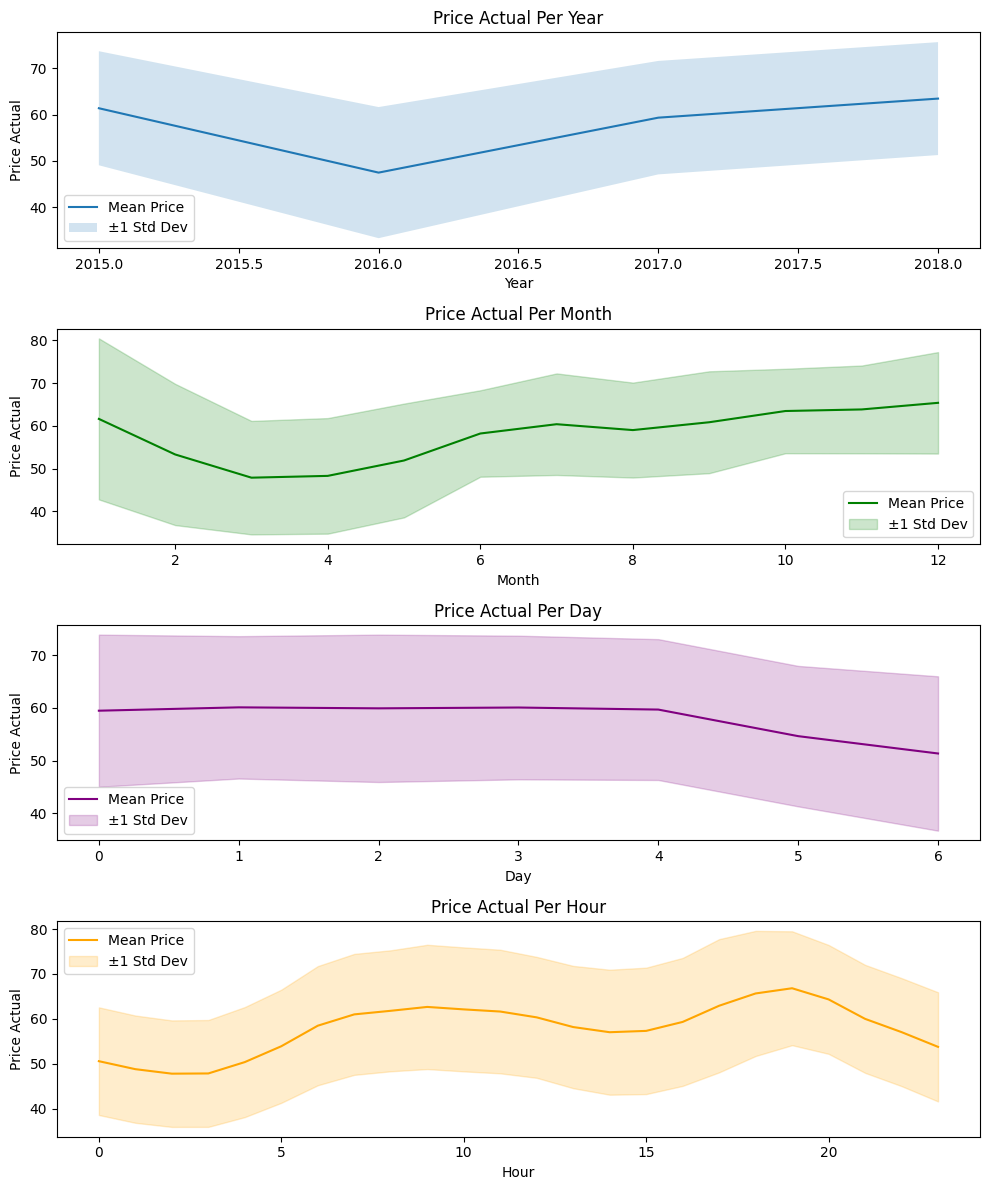

In [48]:
plot_timeframe_data(combined_data.data,"price actual")

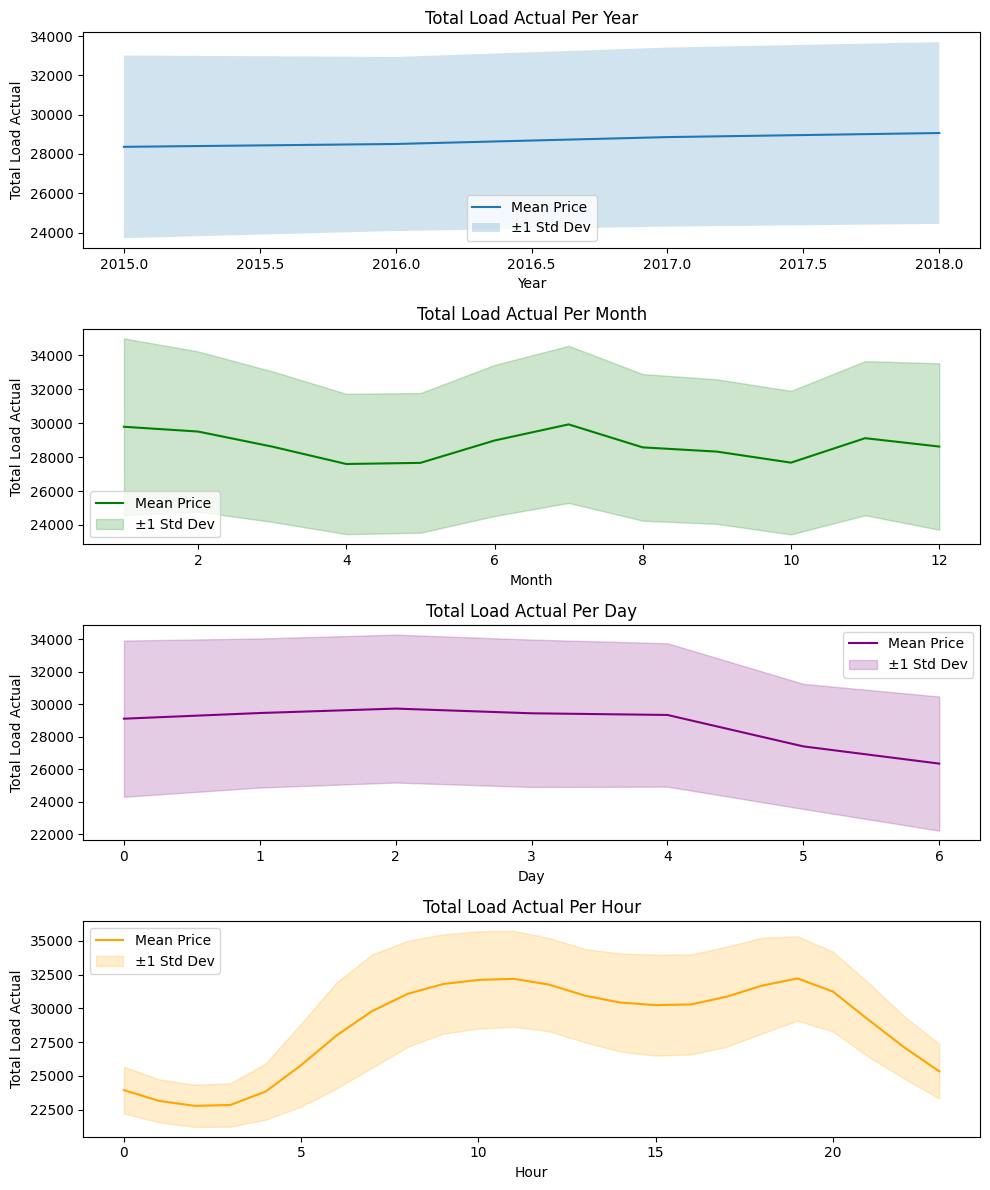

In [49]:
#Actual load
plot_timeframe_data(combined_data.data,"total load actual")

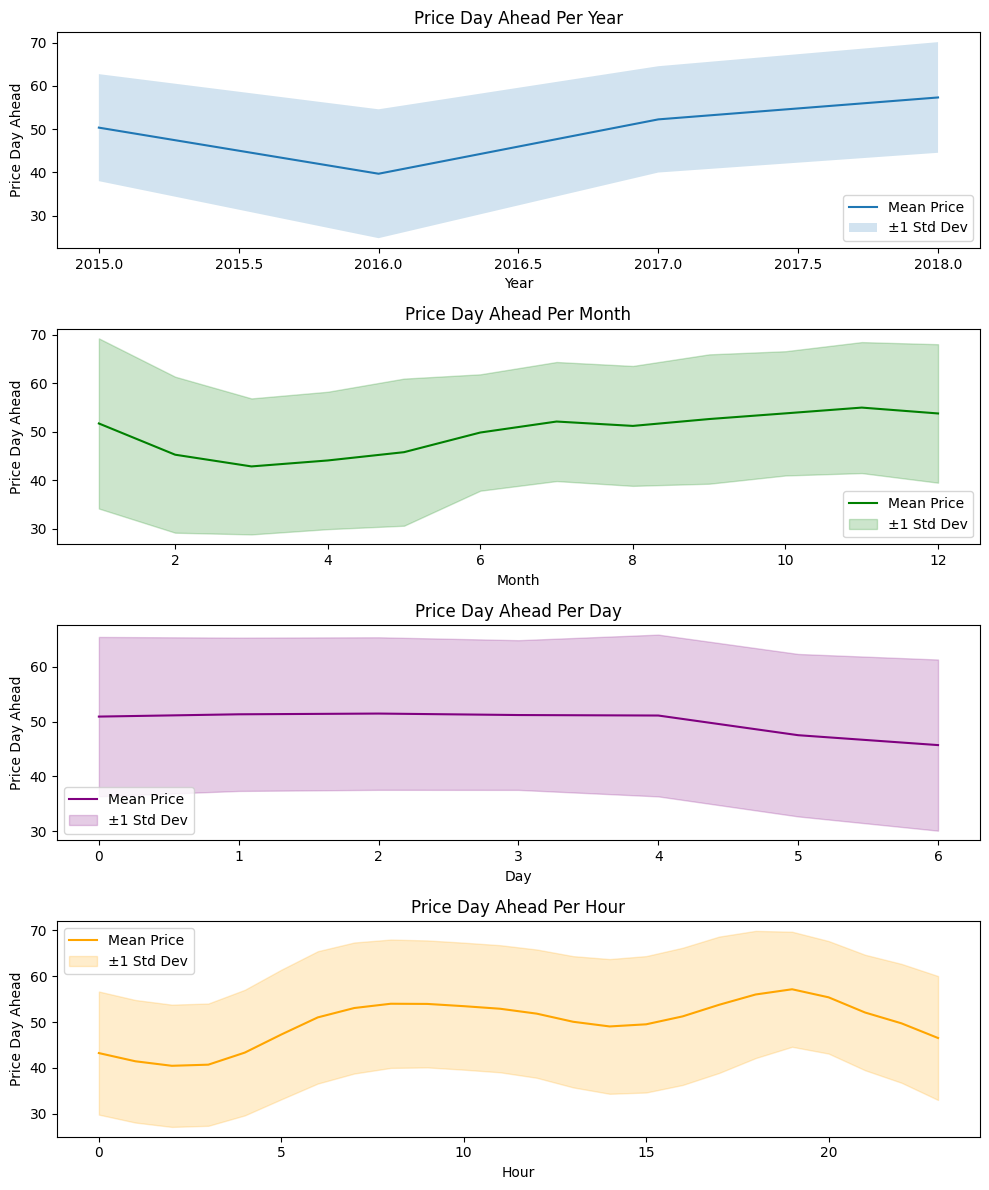

In [50]:
#Day-ahead price
plot_timeframe_data(combined_data.data,"price day ahead")

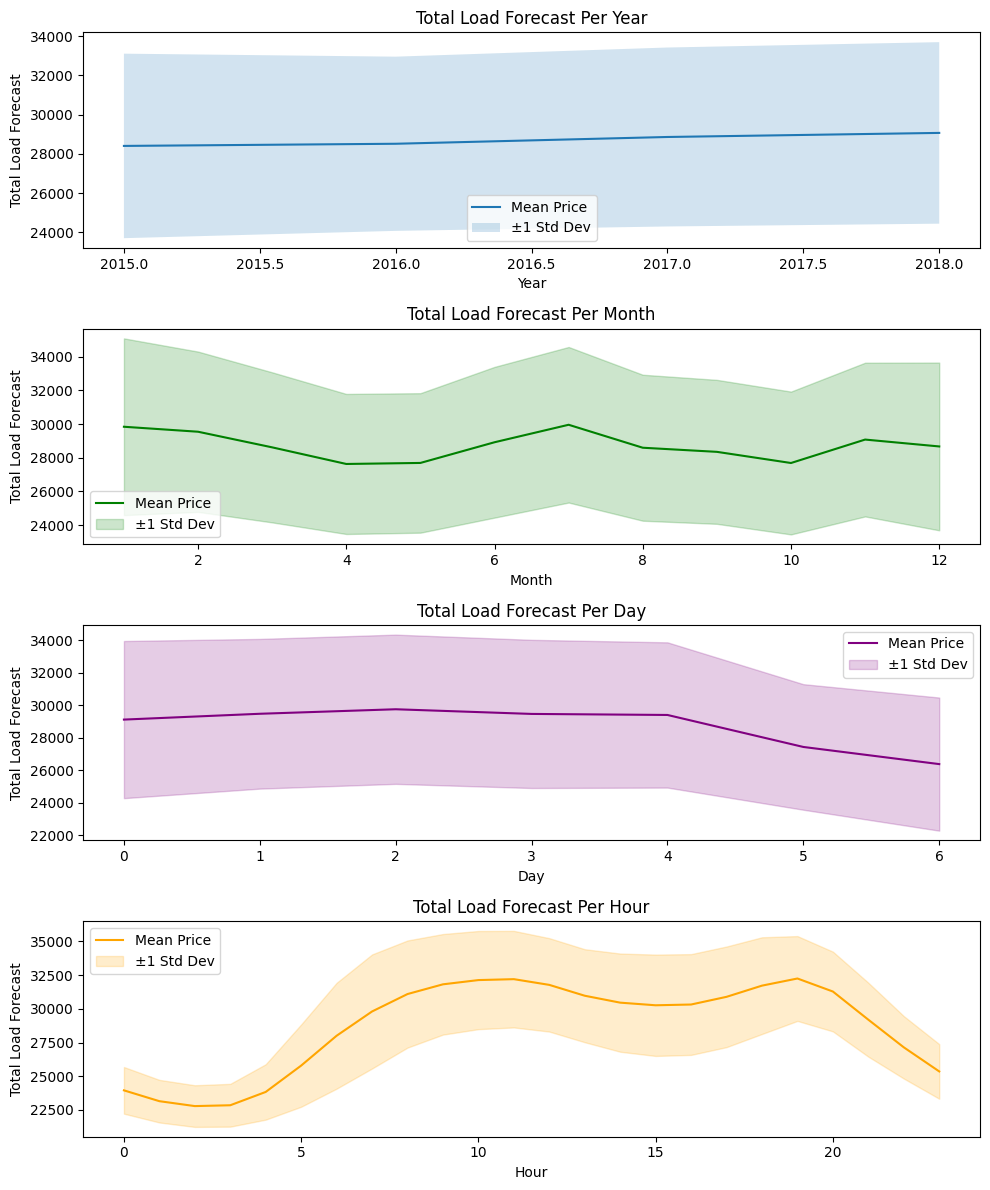

In [51]:
#Predicted load
plot_timeframe_data(combined_data.data,"total load forecast")

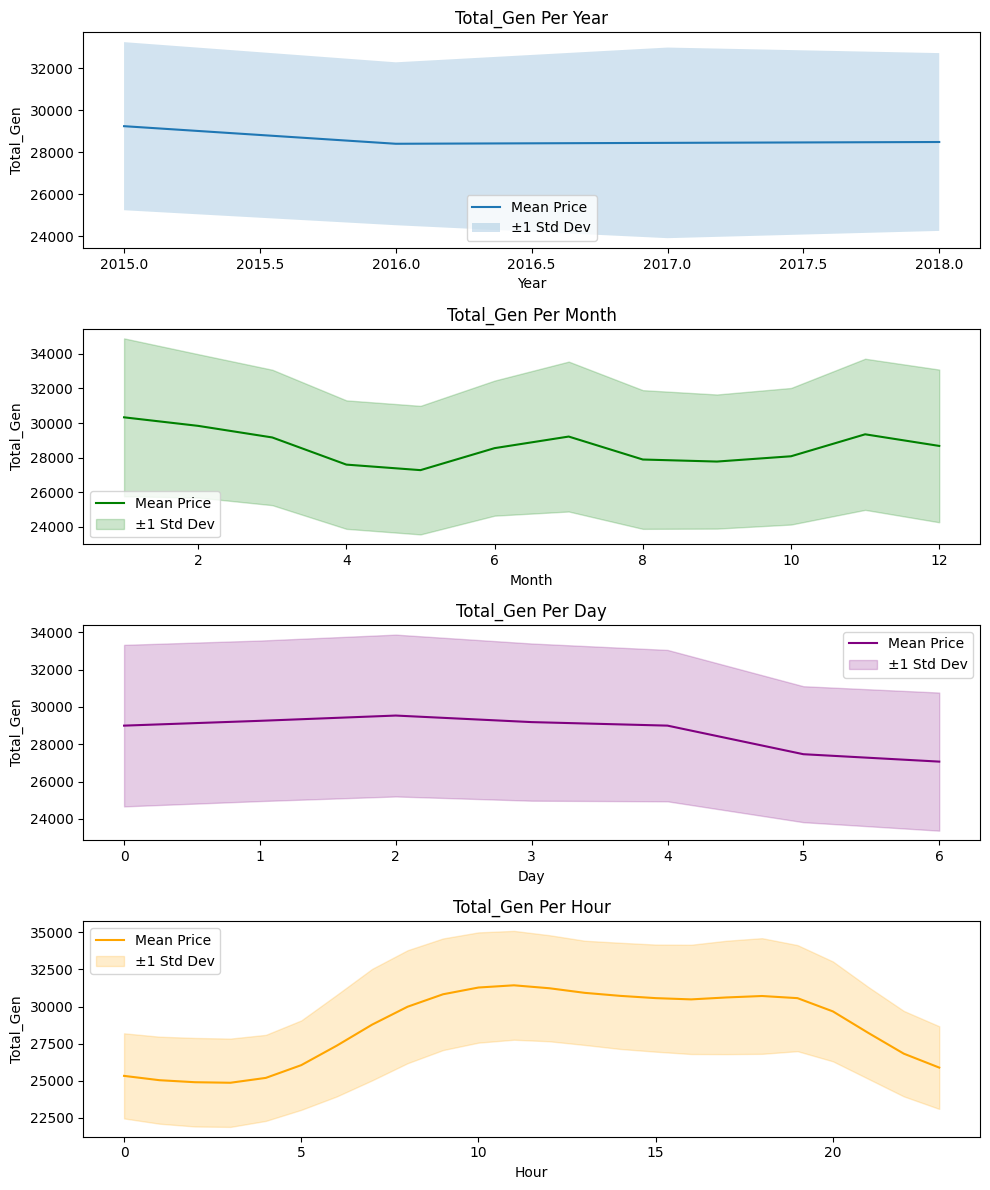

In [52]:
plot_timeframe_data(combined_data.data,"total_gen")

Price is correlated with load and generation. But during the hours between 9 and 18, generation stays semi-consistent while load and price decrease from first peak till 15, then increase till 18. Seasonal, and cylical trends exist as well. Generation is typically equal to load as well. Likely to balance supply and demand, and the grid frequency.

In [53]:
#export to excel for feature engineering
combined_data.data.to_csv(r"engineered_data/transformed_data_first_rev.csv", index=False)